# PART1: SQL

In [1]:
sql="""

select 
count(distinct case when first_buffer-start_time<=5*60 and first_buffer-start_time>=0 
then play_start.playback_session_id end) as rebuffer_cnt 
from 
(select 
playback_session_id, timestamp as start_time
from player_event 
where event_type='player_start'
) as play_start
join 
(select 
playback_session_id, min(timestamp) as first_buffer  
from player_event 
where event_type='player_buffer'
group by session_id 
) as play_buffer 
on play_start.playback_session_id=play_buffer.playback_session_id

"""

# PART2: ANALYSIS

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import scipy.stats as stats
import seaborn as sns
import math
import random
plt.style.use('ggplot')

In [3]:
df=pd.read_csv('/Users/didi/Desktop/data analyst take home exam.csv')
df.head()

,timestamp,autoplay,bitrate,content_type,content_genre,playback_start_source,device_platform,player_device_platform,device_model,player_version,network_mode,user_geoip_region,user_geoip_isp,rebuffer_count,rebuffer_duration,playback_duration,has_fatal_error
0,1.610000e+12,False,6593.0,episode,"[""Drama"",""Medical""]",end_card,George,Hulu FireTV,AFTS,1.94.6,wifi,az,valley connections llc,0,0,2587349,False
1,1.610000e+12,True,8028.0,episode,"[""Drama"",""Romance""]",autoplay,BrightScript,Hulu Roku,3930X,6.37.2,wifi,ny,charter communications inc,0,0,2517000,False
2,1.610000e+12,False,7021.0,episode,"[""Comedy"",""Classics"",""Sitcom""]",browse,George,Hulu FireTV,AFTT,1.94.6,wifi,il,att corp.,0,0,1335858,False
3,1.610000e+12,False,6758.0,episode,"[""Family"",""Animation"",""Adventure"",""Kids"",""Cart...",browse,BrightScript,Hulu Roku,7000X,6.37.2,wifi,wi,charter communications inc,0,0,48000,False
4,1.610000e+12,False,6824.0,episode,"[""News""]",live_guide,BrightScript,Hulu Roku,3921X,6.37.2,wifi,oh,massillon cable com,0,0,47000,False


In [4]:
df.shape

(286982, 17)

## 1. EDA

#### Through EDA , I found:  
1. all the timestamp values in this dataset is the same, so **we cannot gain any information from time**
2. distribution of bitrate and playback duration are long-tailed
3. according to analysis on categorical features:  
-- Major of playbacks is **episode watching**  
-- Top 2 sources are **browser and autoplay**.  
-- **Hulu Roku** is the most popular device, contributed to around 30% of playbacks.  
-- **wifi** accounts for 72% of playbacks.  
-- 1/3 of playbacks are about **Comedy** related content, Animation,Sitcom and drama are also popular.    
-- **CA and TX** had the most playbacks.   
-- There are over thousand internet suppliers, but the biggest 3 companies account for over 50% usage.

In [5]:
# timestamp
df.timestamp.unique()

array([1.61e+12])

In [6]:
# check data type
df.dtypes

timestamp                 float64
autoplay                     bool
bitrate                   float64
content_type               object
content_genre              object
playback_start_source      object
device_platform            object
player_device_platform     object
device_model               object
player_version             object
network_mode               object
user_geoip_region          object
user_geoip_isp             object
rebuffer_count              int64
rebuffer_duration           int64
playback_duration           int64
has_fatal_error              bool
dtype: object

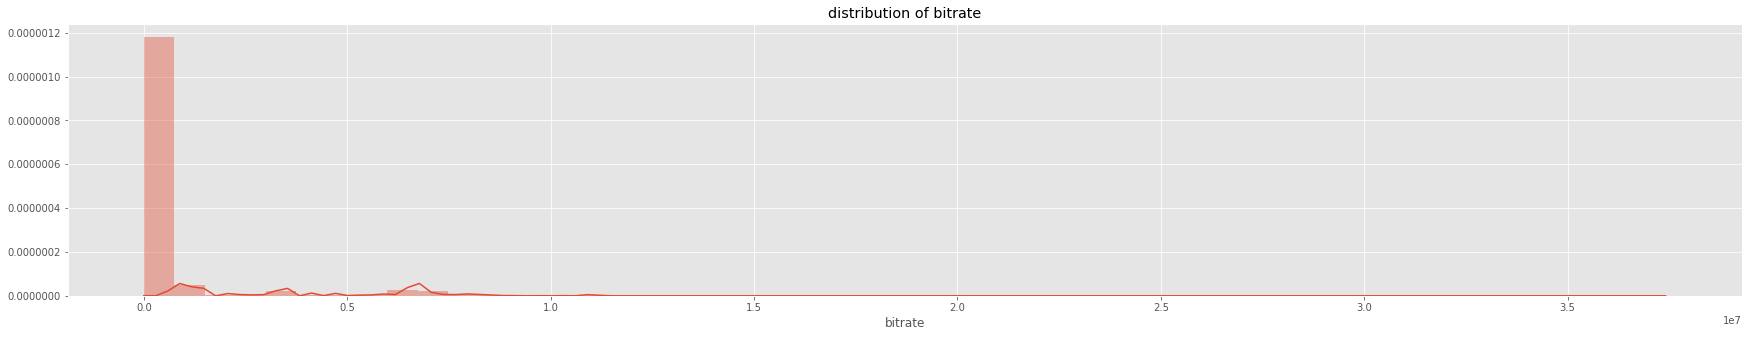

In [7]:
# check distribution of numerical variables
plt.figure(figsize=(30,5))
g=sns.distplot(df.bitrate.dropna())
g.set_title('distribution of bitrate')
plt.show()

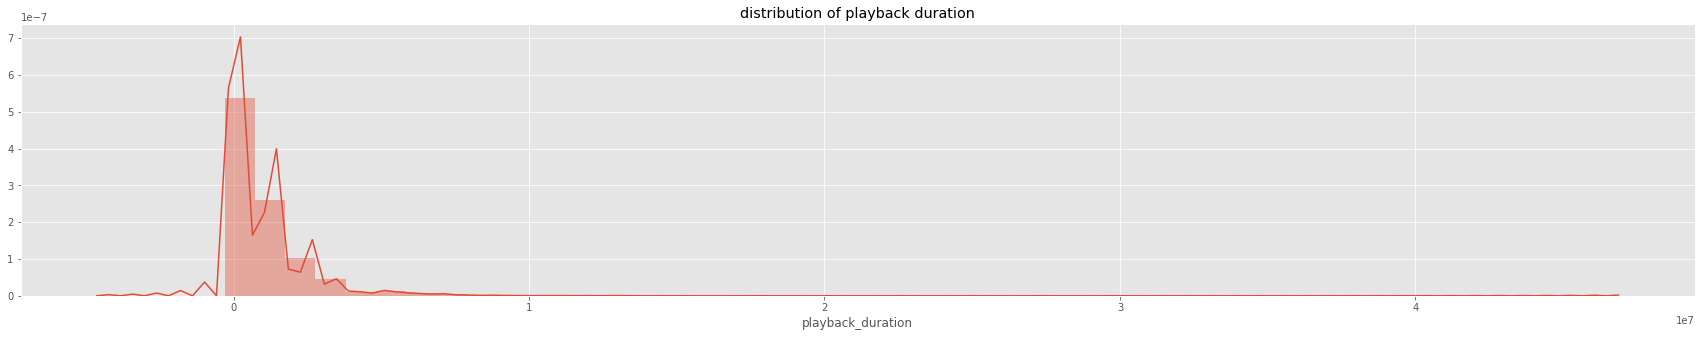

In [8]:
plt.figure(figsize=(30,5))
g=sns.distplot(df.playback_duration.dropna())
g.set_title('distribution of playback duration')
plt.show()

In [9]:
np.percentile(df.playback_duration.dropna(),[5,25,50,75,95])

array([      0. ,    8576. ,  558696. , 1423324.5, 3479503.6])

In [10]:
# no correlation among two numerical variables
df[['bitrate','playback_duration']].dropna().corr()

,bitrate,playback_duration
bitrate,1.000000,-0.031139
playback_duration,-0.031139,1.000000


In [18]:
# check distribution of some catergorical variables, ignore those with too many unique classes. 
for i in [x for x in df.columns if df[x].dtypes=='object']:
    print(i, len(df[i].unique()))

content_type 5
content_genre 2323
playback_start_source 9
device_platform 8
player_device_platform 24
device_model 1996
player_version 131
network_mode 34
user_geoip_region 239
user_geoip_isp 5842


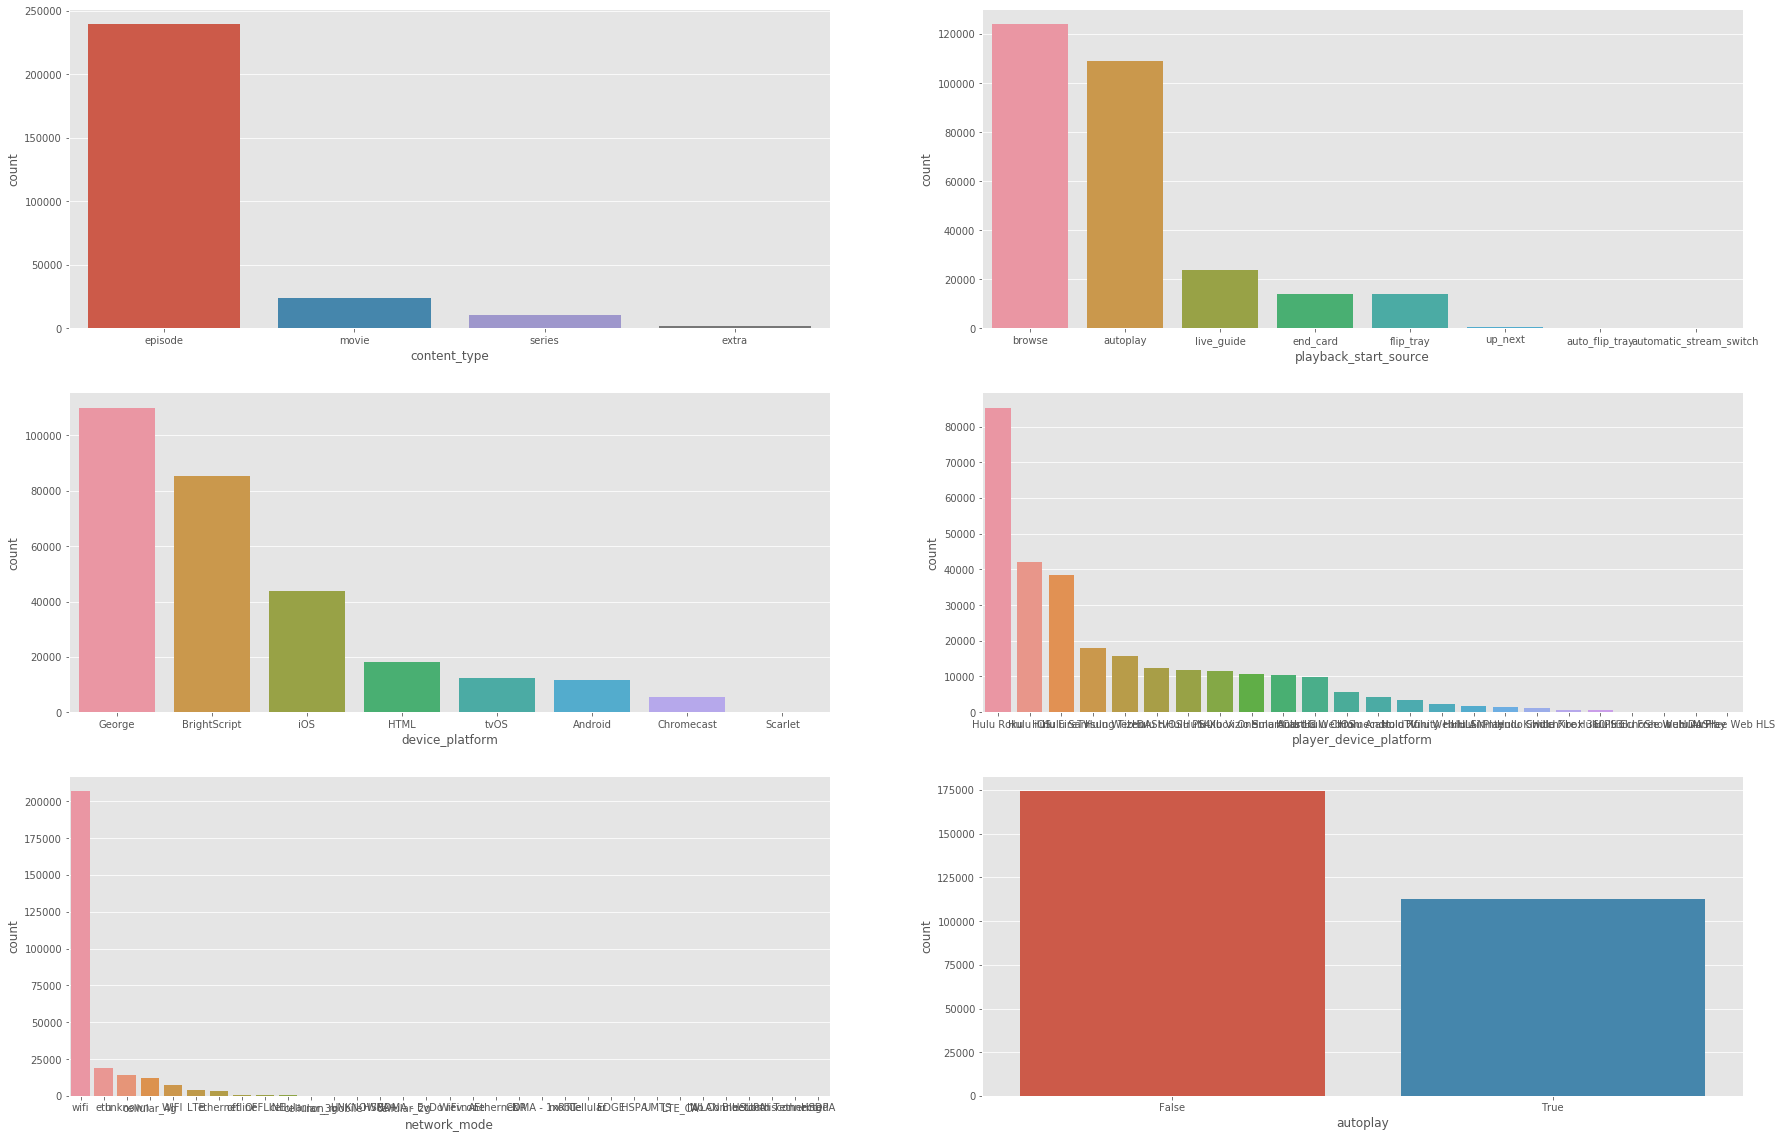

In [19]:
cat_dis=['content_type',
 'playback_start_source',
 'device_platform',
 'player_device_platform',
 'network_mode',
 'autoplay']

fig,ax=plt.subplots(ncols=2,nrows=3,figsize=(30,20))

for i in range(12):
    try:
        p=sns.countplot(x=cat_dis[i],data=df,ax=ax.flatten()[i],
                       order=df[cat_dis[i]].value_counts().index) 
        p.show()
    except:
        pass


In [3]:
#analysis on content genre 
genre=df['content_genre'].astype('str').apply(lambda x:x.replace('[','').replace(']','').split(','))
genre_all=genre.sum()

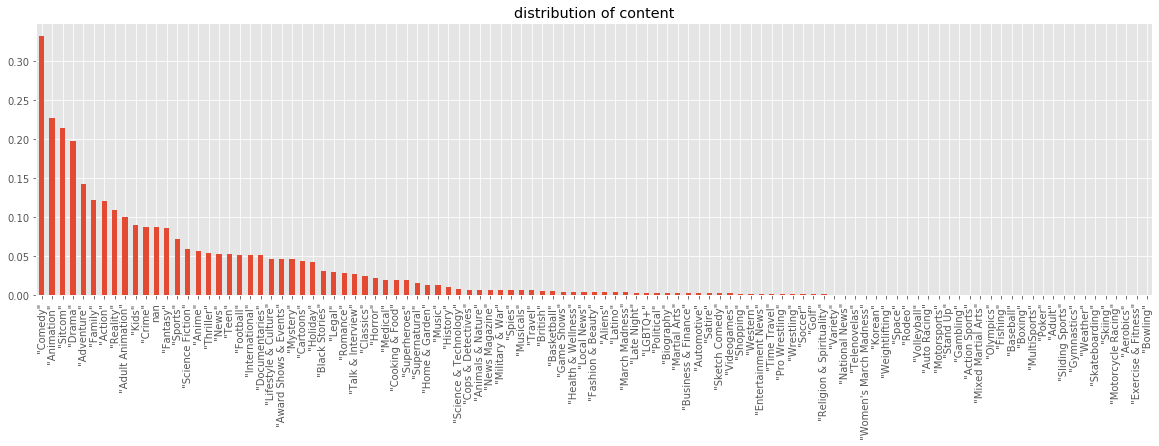

In [324]:
from collections import Counter
x=pd.DataFrame.from_dict(Counter(genre_all), orient='index').sort_values(by=0,ascending=False)/df.shape[0]
plt.figure(figsize=(20,5))
x[0].plot(kind='bar')
plt.title('distribution of content')
plt.show()

In [4]:
df['is_comedy']=df['content_genre'].astype('str').apply(lambda x: 1 if "Comedy" in x else 0)
df['is_animation']=df['content_genre'].astype('str').apply(lambda x: 1 if "Animation" in x else 0)
df['is_sitcom']=df['content_genre'].astype('str').apply(lambda x: 1 if "Sitcom" in x else 0)
df['is_drama']=df['content_genre'].astype('str').apply(lambda x: 1 if "Drama" in x else 0)

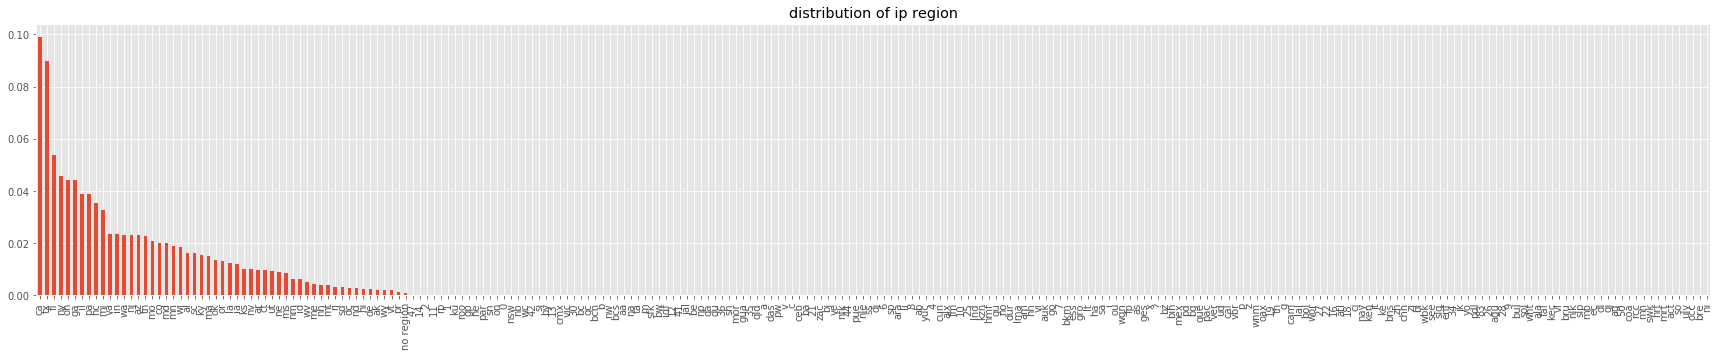

In [20]:
plt.figure(figsize=(30,5))
(df['user_geoip_region'].value_counts()/df.shape[0]).plot(kind='bar')
plt.title('distribution of ip region')
plt.show()

In [24]:
#simplify user_geoip_isp
df['ip_isp_simplify']=df['user_geoip_isp'].astype('str').apply(lambda x:x.split(' ')[0])
(df['ip_isp_simplify'].value_counts()/df.shape[0]).cumsum().iloc[:10]

charter        0.219115
comcast        0.411092
att            0.539212
cox            0.586086
centurylink    0.628684
mci            0.666934
verizon        0.701831
t-mobile       0.733705
optimum        0.748559
suddenlink     0.760330
Name: ip_isp_simplify, dtype: float64

In [22]:
len(df['ip_isp_simplify'].unique())

3435

**check missing values**  
play sessions with missing value has higher error rate (especially for bitrate missing and content genre missing).   
Missing value is not random and cannot be removed in this case.

In [23]:
# check missing value rate
df.isnull().sum()/df.shape[0]

timestamp                 0.000000
autoplay                  0.000000
bitrate                   0.109651
content_type              0.037915
content_genre             0.087413
playback_start_source     0.002272
device_platform           0.000000
player_device_platform    0.000000
device_model              0.000000
player_version            0.000070
network_mode              0.062729
user_geoip_region         0.000014
user_geoip_isp            0.000014
rebuffer_count            0.000000
rebuffer_duration         0.000000
playback_duration         0.000000
has_fatal_error           0.000000
ip_isp_simplify           0.000000
dtype: float64

In [6]:
# QoS metrics under missing value 
df['if_bitrate_miss']=np.where(df.bitrate.isnull(),1,0)
df.groupby('if_bitrate_miss')['rebuffer_duration'].sum()/df.groupby('if_bitrate_miss')['playback_duration'].sum()

if_bitrate_miss
0    0.004304
1    0.002110
dtype: float64

In [25]:
df.groupby('if_bitrate_miss')['has_fatal_error'].sum()/df.groupby('if_bitrate_miss')['has_fatal_error'].size()

if_bitrate_miss
0    0.296129
1    0.880641
Name: has_fatal_error, dtype: float64

In [7]:
df['if_genre_miss']=np.where(df.content_genre.isnull(),1,0)
df.groupby('if_genre_miss')['rebuffer_duration'].sum()/df.groupby('if_genre_miss')['playback_duration'].sum()

if_genre_miss
0    0.004196
1    0.007732
dtype: float64

In [8]:
df.groupby('if_genre_miss')['has_fatal_error'].sum()/df.groupby('if_genre_miss')['has_fatal_error'].size()

if_genre_miss
0    0.326996
1    0.707088
Name: has_fatal_error, dtype: float64

In [28]:
df['if_network_miss']=np.where(df.network_mode.isnull(),1,0)
df.groupby('if_network_miss')['rebuffer_duration'].sum()/df.groupby('if_network_miss')['playback_duration'].sum()

if_network_miss
0    0.004296
1    0.004124
dtype: float64

In [29]:
df.groupby('if_network_miss')['has_fatal_error'].sum()/df.groupby('if_network_miss')['has_fatal_error'].size()

if_network_miss
0    0.356997
1    0.408399
Name: has_fatal_error, dtype: float64

## 2. QoS metrics by dimensions

### single variable analysis   
* playback source of browser shows higher rebuffer rate and error rate compared to other sources.   
* network of wifi has better performance in terms of these two metrics.   
* play session with suppliers of comcast and charter have lower numbers of rebuffer rate and error rate.  
* autoplay helps with reduce rebuffer rate and error rate.  

Other feature or property didn't show exactly same trend for rebuffer rate and error rate.   
But Chi-square independent test results indicate all variables are related to error rate. And we also see difference in rebuffer rate.


In [9]:
# data precossing 
# cut numerical features into groups
df['bitrate_bin']=pd.cut(df['bitrate'],np.percentile(df.bitrate.dropna(),[5,25,50,75,95]))
df['bitrate_bin']=np.where(df['bitrate_bin'].isnull(),'missing_value',df['bitrate_bin'])


df['playback_duration_bin']=pd.cut(df['playback_duration'],np.percentile(df.bitrate.dropna(),[5,25,50,75,95]))
df['playback_duration_bin']=np.where(df['playback_duration_bin'].isnull(),'missing_value',df['playback_duration_bin'])

In [28]:
# data precossing 
# reduce number of categories for some features
df['network_mode_new']=np.where(df['network_mode'].isnull(),'missing_value',df['network_mode'])
df['network_mode_new']=np.where(df['network_mode_new'].isin(['wifi','missing_value']),df['network_mode_new'],'other')

df['region_new']=np.where(df['user_geoip_region'].isin(['ca','tx']),df['user_geoip_region'],'other')

df['ip_isp_simplify']=np.where(df['ip_isp_simplify'].isin(['charter','comcast','att' ]),
                                df['ip_isp_simplify'],'other')


In [11]:
# define functions to calculate metrics
def get_metrics(df,cols):
    rebuffer=pd.DataFrame(df.groupby(cols)['rebuffer_duration'].sum()/
                          df.groupby(cols)['playback_duration'].sum())
    rebuffer=rebuffer.rename(columns={0:'rebuffer_rate'})
    
    fig, ax = plt.subplots(figsize=(10,5))
    rebuffer.rebuffer_rate.plot(kind='line',color='red',ax=ax,label='rebuffer_rate')
    ax.legend(loc='upper left')
    
    ax2=ax.twinx()
    error=pd.DataFrame(df.groupby(cols)['has_fatal_error'].sum()/df.groupby(cols)['has_fatal_error'].size())
    error=error.rename(columns={'has_fatal_error':'error_rate'})
    error.error_rate.plot(kind='line',color='blue',ax=ax2,label='error_rate')
    ax2.legend(loc='upper right')
    
    chi2, p, dof, ex =stats.chi2_contingency(pd.crosstab(df[cols], df['has_fatal_error']))
    print('Chi Square Test of independence between has_fatal_error and',cols,':')
    if p<0.05:
        print('p_value is {:.2f} ,two variables are not independent'.format(p))
    else:
        print('p_value is {:.2f} ,two variables are independent'.format(p))

In [12]:
# define functions to calculate metrics
def get_rebuffer_rate(df,cols):
    rebuffer=pd.DataFrame(df.groupby(cols)['rebuffer_duration'].sum()/
                          df.groupby(cols)['playback_duration'].sum())
    rebuffer=rebuffer.rename(columns={0:'rebuffer_rate'})
    
    return(rebuffer)

def get_error_rate(df,cols):
    error=pd.DataFrame(df.groupby(cols)['has_fatal_error'].sum()/df.groupby(cols)['has_fatal_error'].size())
    error=error.rename(columns={'has_fatal_error':'error_rate'})
    
    return(error)

### Rebuffer rate & Error rate among dimensions

Chi Square Test of independence between has_fatal_error and bitrate_bin :
p_value is 0.00 ,two variables are not independent


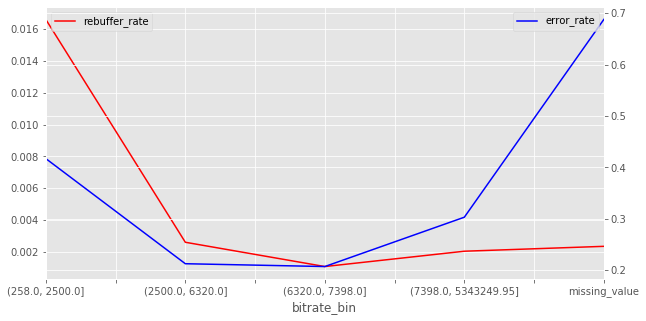

In [34]:
get_metrics(df,'bitrate_bin')

Chi Square Test of independence between has_fatal_error and playback_duration_bin :
p_value is 0.00 ,two variables are not independent


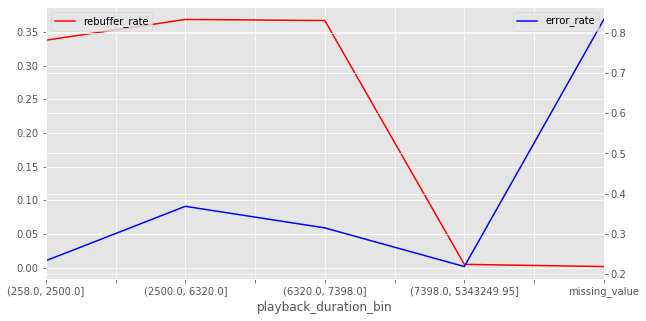

In [35]:
get_metrics(df,'playback_duration_bin')

Chi Square Test of independence between has_fatal_error and content_type :
p_value is 0.00 ,two variables are not independent


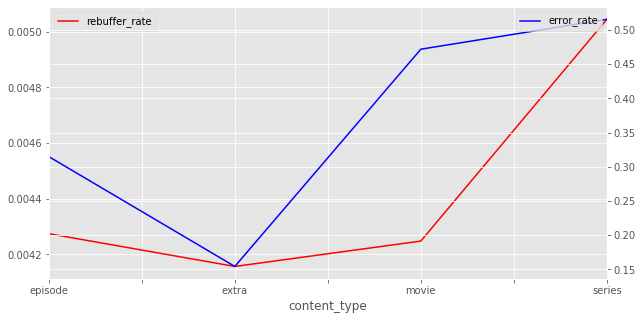

In [36]:
get_metrics(df,'content_type')

Chi Square Test of independence between has_fatal_error and playback_start_source :
p_value is 0.00 ,two variables are not independent


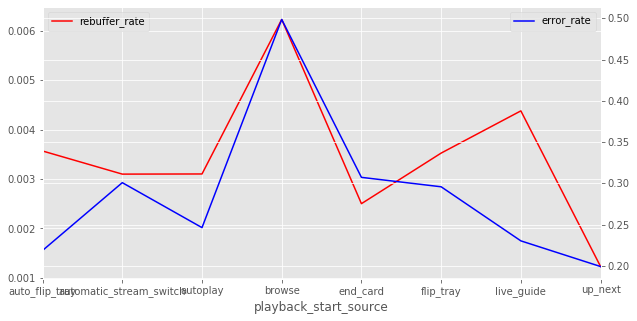

In [37]:
get_metrics(df,'playback_start_source')

Chi Square Test of independence between has_fatal_error and device_platform :
p_value is 0.00 ,two variables are not independent


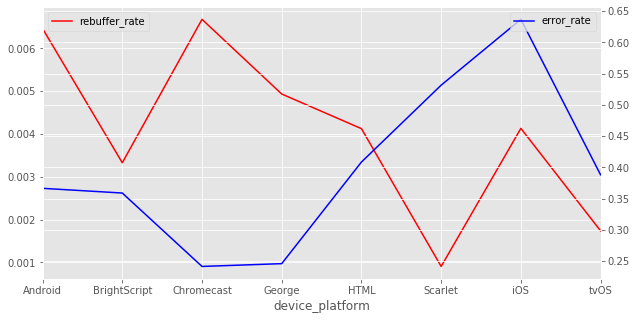

In [38]:
get_metrics(df,'device_platform')

Chi Square Test of independence between has_fatal_error and player_device_platform :
p_value is 0.00 ,two variables are not independent


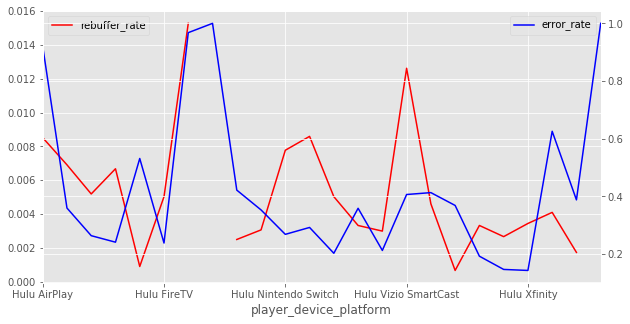

In [39]:
get_metrics(df,'player_device_platform')

Chi Square Test of independence between has_fatal_error and network_mode_new :
p_value is 0.00 ,two variables are not independent


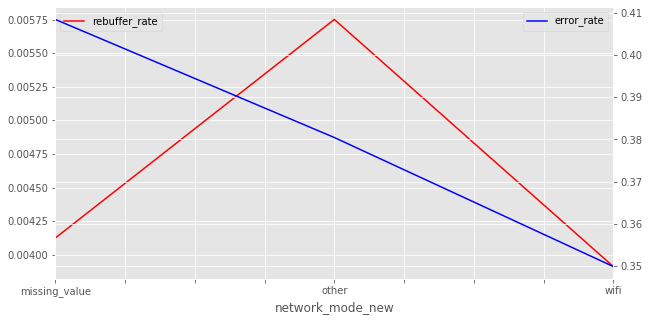

In [40]:
get_metrics(df,'network_mode_new')

Chi Square Test of independence between has_fatal_error and region_new :
p_value is 0.00 ,two variables are not independent


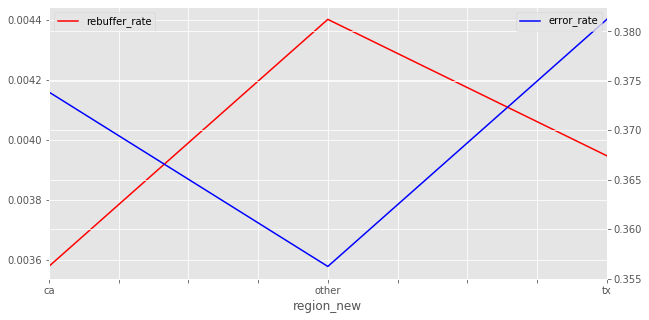

In [41]:
get_metrics(df,'region_new')

Chi Square Test of independence between has_fatal_error and ip_isp_simplify :
p_value is 0.00 ,two variables are not independent


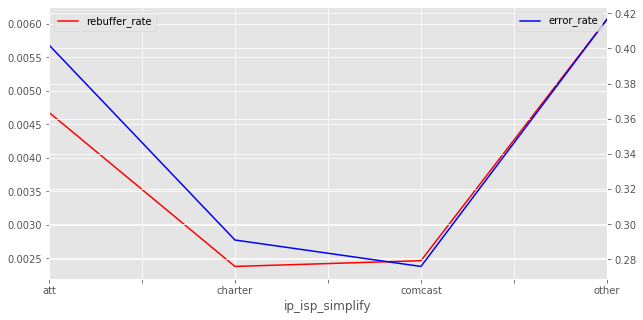

In [42]:
get_metrics(df,'ip_isp_simplify')

Chi Square Test of independence between has_fatal_error and autoplay :
p_value is 0.00 ,two variables are not independent


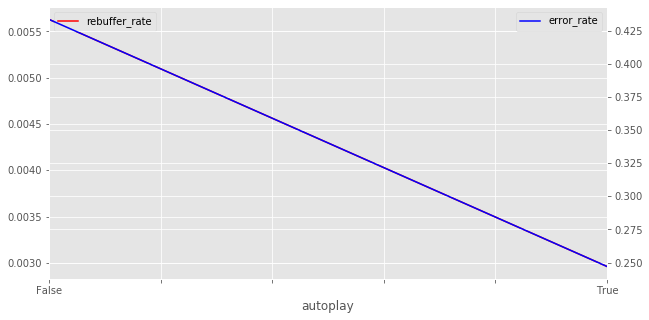

In [43]:
get_metrics(df,'autoplay')

Chi Square Test of independence between has_fatal_error and is_comedy :
p_value is 0.00 ,two variables are not independent


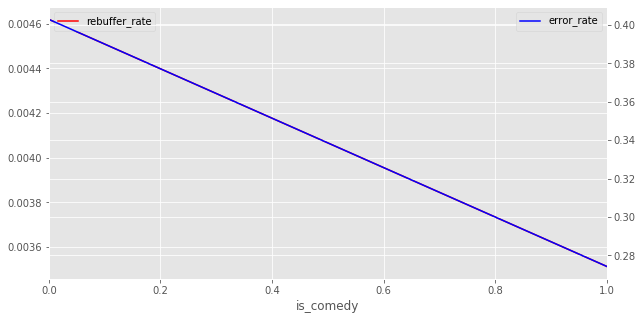

In [46]:
get_metrics(df,'is_comedy')

Chi Square Test of independence between has_fatal_error and is_animation :
p_value is 0.00 ,two variables are not independent


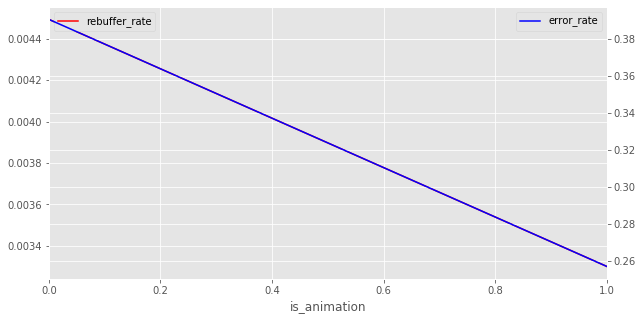

In [47]:
get_metrics(df,'is_animation')

## 3. Prediction model for rebuffer  
Whether the session will have a rebuffer is a **classification problem.**    

I decided to use **xgboost** to develop this prediction model: the model shows **overall AUC score about 80%** for both training and testing sets. Though the precision score is low, but given this case, it is also acceptable.

The most importance variables to if rebuffer are **device platform, player device platform, playback duration, autoplay and bitrate.**

Due to time constraint, I didn't finish parameter tuning for xgboost model. Otherwise, the overall performance of model could be better.

In [14]:
# define y label for classification model
df['is_rebuffer']=np.where(df.rebuffer_count>0,1,0)
df['is_rebuffer'].value_counts()

0    241463
1     45519
Name: is_rebuffer, dtype: int64

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
import sklearn.metrics as metrics
from xgboost import plot_importance
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix

In [16]:
# convert categorical variables into numerical, so that machine learning models can deal with
cat = df[['content_type', 
       'playback_start_source', 'device_platform', 'player_device_platform',
       'ip_isp_simplify', 'network_mode_new',
       'region_new']]

no_cat = df[['autoplay',
 'bitrate',
 'is_animation',
 'is_comedy',
 'is_drama',
 'is_sitcom',
 'playback_duration']].fillna(-1)


cat = cat.fillna("missing_value")
cat_lbl = pd.get_dummies(cat,drop_first=True) #get dummy variables

x = pd.concat([cat_lbl, no_cat], axis=1, ignore_index=True)
y = df['is_rebuffer']
 

### try **simply logistic regression** 
But result is bad

In [52]:
from sklearn.linear_model import LogisticRegression
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)  

lg=LogisticRegression().fit(x_train,y_train)
roc_auc = metrics.roc_auc_score(y_train, lg.predict(x_train))

print('AUC of train set = {:.1%}'.format( roc_auc )) 

AUC of train set = 44.0%


In [54]:
print('AUC of test set = {:.1%}'.format( metrics.roc_auc_score(y_test,lg.predict(x_test))  )) 
print('Accuracy of test set = {:.1%}'.format( metrics.accuracy_score(y_test,lg.predict(x_test))  )) 
print('Precision of test set = {:.1%}'.format( metrics.precision_score(y_test,lg.predict(x_test))  )) 
print('Recall of test set = {:.1%}'.format( metrics.recall_score(y_test,lg.predict(x_test))  )) 

AUC of test set = 44.0%
Accuracy of test set = 73.9%
Precision of test set = 0.2%
Recall of test set = 0.1%


### use **xgboost model** to improve prediction ability   
Overall AUC score is satisfied, but model shows low precision score, means too many false positive.    
But when doing anomaly detection, false negative is more crucial, so low precision is acceptable.

The most importance variables to if rebuffer are **device platform, player device platform, playback duration, autoplay and bitrate.**

In [17]:
x.columns=list(cat_lbl.columns)+list(no_cat.columns)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)  

model = XGBClassifier(
        objective='binary:logistic', 
       scale_pos_weight=5.3
        ).fit(x_train,y_train)

fpr, tpr, threshold = metrics.roc_curve(y_train, model.predict(x_train))
roc_auc = metrics.roc_auc_score(y_train, model.predict(x_train))

print('AUC of train set = {:.1%}'.format( roc_auc )) 

AUC of train set = 80.0%


In [56]:
print('AUC of test set = {:.1%}'.format( metrics.roc_auc_score(y_test,model.predict(x_test))  )) 
print('Accuracy of test set = {:.1%}'.format( metrics.accuracy_score(y_test,model.predict(x_test))  )) 
print('Precision of test set = {:.1%}'.format( metrics.precision_score(y_test,model.predict(x_test))  )) 
print('Recall of test set = {:.1%}'.format( metrics.recall_score(y_test,model.predict(x_test))  )) 

AUC of test set = 79.7%
Accuracy of test set = 80.3%
Precision of test set = 43.4%
Recall of test set = 78.9%


In [57]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test,model.predict(x_test)).flatten()
(tn, fp, fn, tp)

(48630, 11720, 2410, 8986)

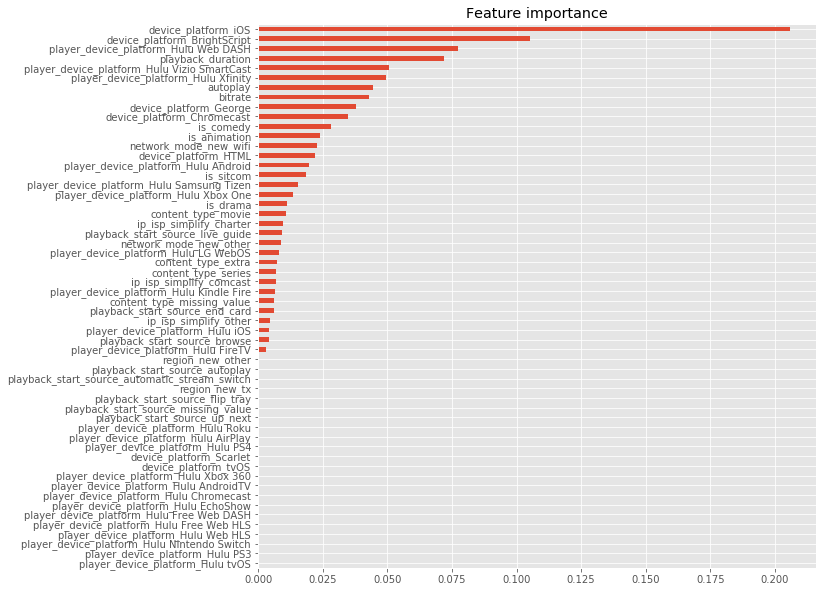

In [30]:
plt.figure(figsize=(10,10))
pd.Series(model.feature_importances_,
          index=x.columns).sort_values().plot(kind='barh')
plt.title('Feature importance')
plt.show()

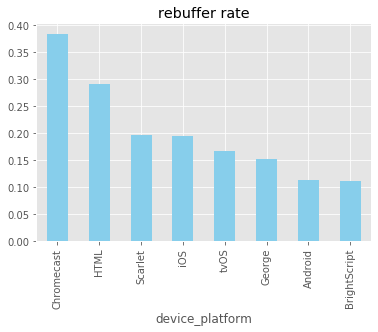

In [34]:
(df.groupby('device_platform')['is_rebuffer'].sum()/df.groupby('device_platform')[
    'is_rebuffer'].size()).sort_values(ascending=False).plot(kind='bar',color='skyblue')
plt.title('rebuffer rate')
plt.show()

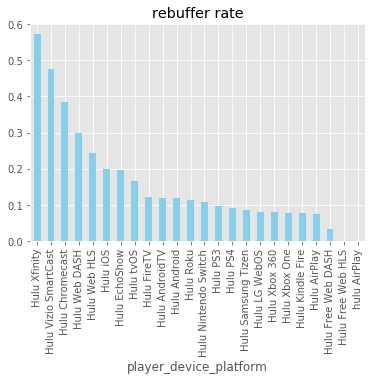

In [35]:
(df.groupby('player_device_platform')['is_rebuffer'].sum()/df.groupby('player_device_platform')[
    'is_rebuffer'].size()).sort_values(ascending=False).plot(kind='bar',color='skyblue')
plt.title('rebuffer rate')
plt.show()

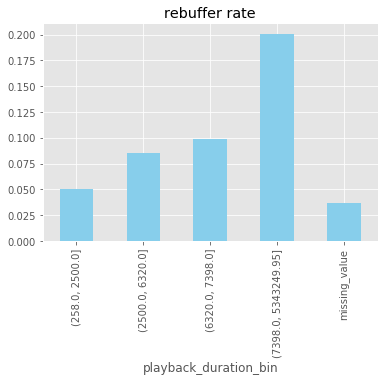

In [36]:
(df.groupby('playback_duration_bin')['is_rebuffer'].sum()/df.groupby('playback_duration_bin')['is_rebuffer'].size()
).plot(kind='bar',color='skyblue')
plt.title('rebuffer rate')
plt.show()

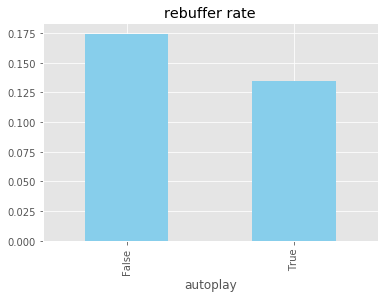

In [37]:
(df.groupby('autoplay')['is_rebuffer'].sum()/df.groupby('autoplay')['is_rebuffer'].size()).plot(
    kind='bar',color='skyblue')
plt.title('rebuffer rate')
plt.show()

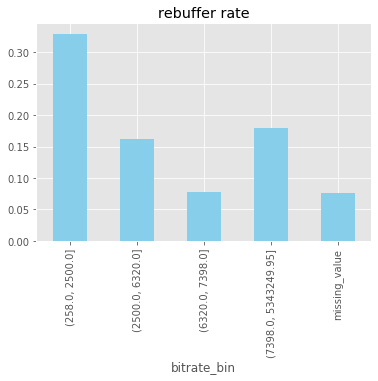

In [38]:
(df.groupby('bitrate_bin')['is_rebuffer'].sum()/df.groupby('bitrate_bin')['is_rebuffer'].size()).plot(
    kind='bar',color='skyblue')
plt.title('rebuffer rate')
plt.show()

In [39]:
df.timestamp.iloc[0]

1610000000000.0

In [45]:
from datetime import datetime
d=datetime.fromtimestamp(1610000000)
d

datetime.datetime(2021, 1, 7, 14, 13, 20)

In [51]:
d.second

20

In [52]:
d.weekday()

3

In [53]:
d.isoweekday()

4

In [54]:
d.strftime("%A")

'Thursday'